Wow, for some reason, now this is working

In [5]:
import tensorflow as tf
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [6]:
# data source: Max Plank Institute, https://www.bgc-jena.mpg.de/wetter/
zip_path = tf.keras.utils.get_file( #
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

print(zip_path)

csv_path, _ = os.path.splitext(zip_path) # https://docs.python.org/3/library/os.path.html
print(csv_path)

# # Load the data and prepare it
data_path = '/root/.keras/datasets/jena_climate_2009_2016.csv'  # Update this with the correct path
df = pd.read_csv(data_path)

# Extract the temperature and date-time columns
uni_data_df = df[['Date Time', 'T (degC)']].copy()

# Convert the 'Date Time' column to datetime format
uni_data_df['Date Time'] = pd.to_datetime(uni_data_df['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Set 'Date Time' as the index
uni_data_df.set_index('Date Time', inplace=True)

# Display the first few rows of the data
uni_data_df.head()

/root/.keras/datasets/jena_climate_2009_2016.csv.zip
/root/.keras/datasets/jena_climate_2009_2016.csv


,T (degC)
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['T (degC)'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['T (degC)'], **{})
chart

In [9]:
# Load the data and prepare it
data_path = '/root/.keras/datasets/jena_climate_2009_2016.csv'  # Update this with the correct path
df = pd.read_csv(data_path)

# Extract the temperature column
uni_data_df = df[['T (degC)']].copy()

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(uni_data_df)

# Convert the scaled data to PyTorch tensors
data_tensor = torch.FloatTensor(scaled_data)

# Define a function to create sequences from the time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+1]
        sequences.append((x, y))
    return sequences

# Set the sequence length
seq_length = 10

# Create sequences
sequences = create_sequences(data_tensor, seq_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_idx = int(len(sequences) * split_ratio)
train_sequences = sequences[:split_idx]
test_sequences = sequences[split_idx:]

# Create DataLoader for training and testing
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_sequences, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_sequences, batch_size=batch_size, shuffle=False)


In [14]:
# Define LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create the model
input_size = 1  # Univariate data
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2

In [15]:
# Inside the training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        batch_x, batch_y = batch_x.float(), batch_y.float()

        # Forward pass
        outputs = model(batch_x)

        # Reshape the target tensor to match the output shape
        batch_y = batch_y.squeeze(dim=1)

        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Evaluation on the test set
    model.eval()
    test_loss = 0
    predictions = []
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.float(), batch_y.float()
        with torch.no_grad():
            outputs = model(batch_x)

            # Reshape the target tensor to match the output shape
            batch_y = batch_y.squeeze(dim=1)

            test_loss += criterion(outputs, batch_y).item()
            predictions.append(outputs.numpy())

    test_loss /= len(test_loader)

    # Calculate RMSE
    predictions = np.concatenate(predictions)
    predictions = scaler.inverse_transform(predictions)
    y_true = scaler.inverse_transform(np.concatenate([y.numpy() for _, y in test_sequences]))
    rmse = np.sqrt(mean_squared_error(y_true, predictions))

    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, np.sqrt(train_loss), rmse))


Epoch 0: train RMSE 0.0295, test RMSE 0.4717
Epoch 1: train RMSE 0.0054, test RMSE 0.2226


In [17]:
print(y_true[0])

[17.15]


In [18]:
print(predictions[0])

[17.197159]


In [20]:
# Generate random data
np.random.seed(0)
data = np.random.rand(10)
actual_value = np.random.rand(1)  # The actual value to predict

In [21]:
# Convert the data to PyTorch tensors
data_tensor = torch.FloatTensor(data).view(1, -1, 1)  # Shape: [1, sequence_length, input_size]

In [23]:
# Make predictions
model.eval()
with torch.no_grad():
    predicted_value = model(data_tensor).item()

In [24]:
print("Actual Value:", actual_value)
print("Predicted Value:", predicted_value)

Actual Value: [0.79172504]
Predicted Value: 0.1300436109304428


In [25]:
# Convert the data to PyTorch tensors
# Assuming you have already defined 'test_sequences'
data_tensor = torch.FloatTensor(test_sequences[0][0]).view(1, -1, 1)  # Use the first sequence in the test data

In [26]:
# Make predictions
model.eval()
with torch.no_grad():
    predicted_value = model(data_tensor).item()  # Use .item() to convert to a scalar value

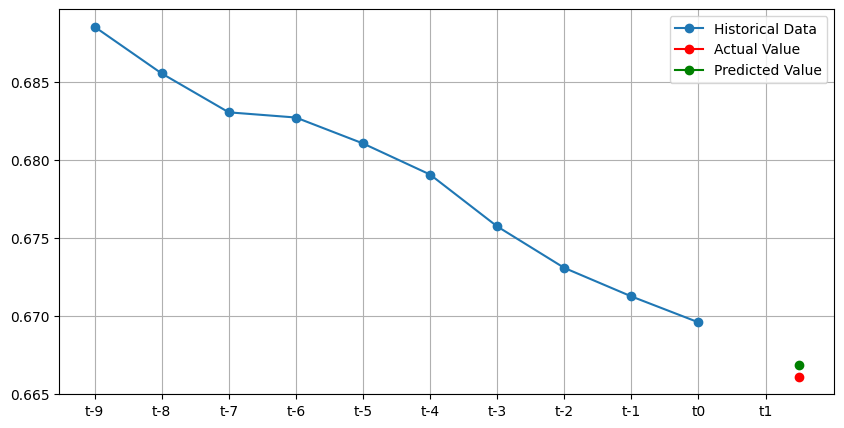

Actual Value: tensor([0.6661])
Predicted Value: 0.6668961048126221


In [29]:
# Plot the historical data, actual value, and predicted value
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 11), test_sequences[0][0], marker='o', label='Historical Data')
plt.plot(11.5, test_sequences[0][1][0], marker='o', label='Actual Value', color='red')
plt.plot(11.5, predicted_value, marker='o', label='Predicted Value', color='green')
plt.xticks(np.arange(1, 12), labels=['t-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 't0', 't1'])
plt.legend()
plt.grid()
plt.show()


# Print the actual and predicted values
print("Actual Value:", test_sequences[0][1][0])
print("Predicted Value:", predicted_value)

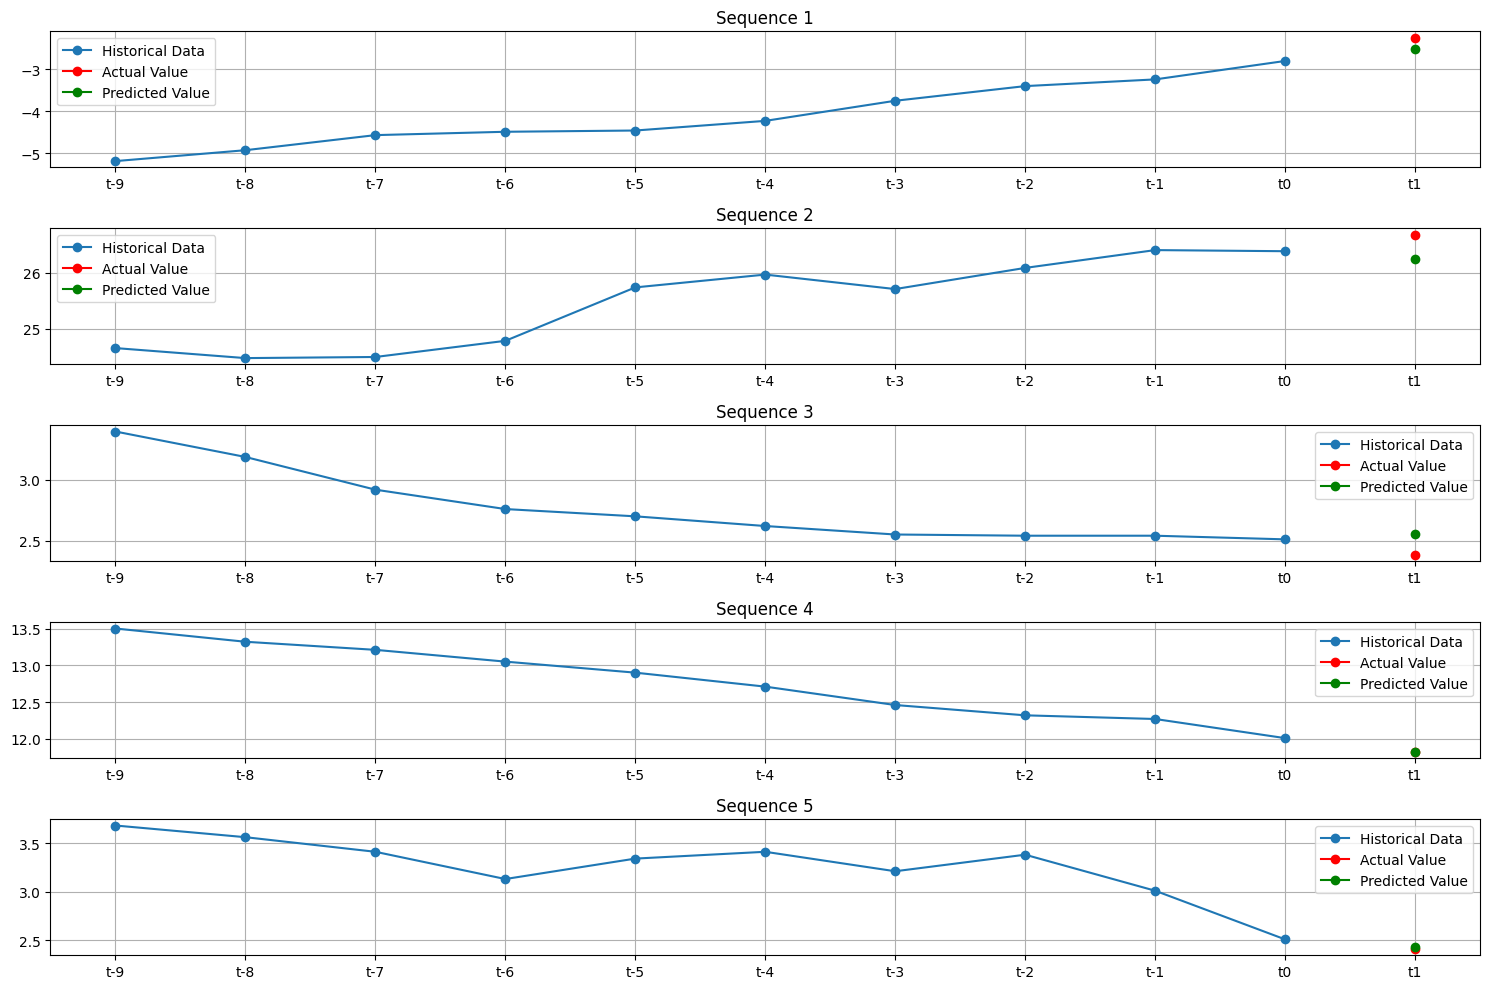

In [33]:
import random

def plot_random_sequences(sequences, model, scaler):
    plt.figure(figsize=(15, 10))
    for _ in range(5):
        random_index = random.randint(0, len(sequences) - 1)
        x, y = sequences[random_index]

        # Convert the sequence to a PyTorch tensor
        x_tensor = torch.FloatTensor(x).view(1, -1, 1)

        # Make predictions
        model.eval()
        with torch.no_grad():
            predicted_value = model(x_tensor).item()

        # Inverse transform the scaled values
        x_original = scaler.inverse_transform(x)
        y_original = scaler.inverse_transform(y)
        predicted_original = scaler.inverse_transform(np.array([[predicted_value]]))

        plt.subplot(5, 1, _ + 1)
        plt.plot(np.arange(1, 11), x_original, marker='o', label='Historical Data')
        plt.plot(11, y_original[0], marker='o', label='Actual Value', color='red')
        plt.plot(11, predicted_original[0][0], marker='o', label='Predicted Value', color='green')
        plt.title(f'Sequence {_ + 1}')
        plt.xticks(np.arange(1, 12), labels=['t-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 't0', 't1'])
        plt.legend()
        plt.grid()
    plt.tight_layout()
    plt.show()

# Call the function to plot random sequences
plot_random_sequences(test_sequences, model, scaler)
